## Import packages, functions

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from data.Data_loader import GravitationalWave_datastrain_New as GW_DS_NEW
from data.Data_loader import Data_set_transform 

from neural.Network import *

if torch.cuda.is_available():
    device = torch.device(0)
    print("GPU OK")
else:
    device = "cpu"
    print("no GPU")
    
    
def plot_sample(sample):
    fig, ax = plt.subplots(3,1, sharex=True, sharey=True)
    t = np.linspace(0,8,65536)
    for i in range(3):
        ax[i].plot(t,sample.numpy()[i], label=f'E{i}')
        ax[i].legend(loc='upper right')
        ax[i].grid()
        ax[i].tick_params(left = False, labelleft = False)
        ax[i].axis([0,8,None,None])
    ax[2].set_xlabel('time(s)')
    plt.tight_layout()
    return fig, ax

/data/gravwav/jlangend/.conda/envs/NAME_ENV/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


no GPU


## Dataloader


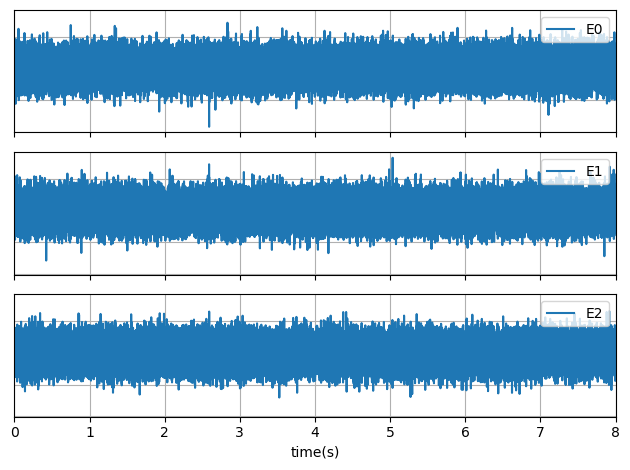

In [2]:
#load data
path = '/data/gravwav/lopezm/ML_projects/Projects_2022/Project_2/Data_new'
data = GW_DS_NEW(path)

#handles the distribution of train/validation/test sets (in fraction)
distribution_trn_val_tst = [0.8,0.1,0.1] #distribution used
data_distribution = len(data)*np.array(distribution_trn_val_tst) 
bounds = np.floor(np.cumsum(data_distribution))

testsize = 128 #number of injections and backgrounds in the test set

testset = data.make_dataset(testsize, data_bounds=[bounds[1],bounds[2]])
Testset = Data_set_transform(testset)
testloader = torch.utils.data.DataLoader(Testset, batch_size=32,
                                          shuffle=True, num_workers=2)
fig, ax = plot_sample(Testset[0][0])

(3, 65536)
eventID: 14454
network output: tensor([[-0.9168,  1.0120]], grad_fn=<AddmmBackward0>)
label: tensor([1, 0])


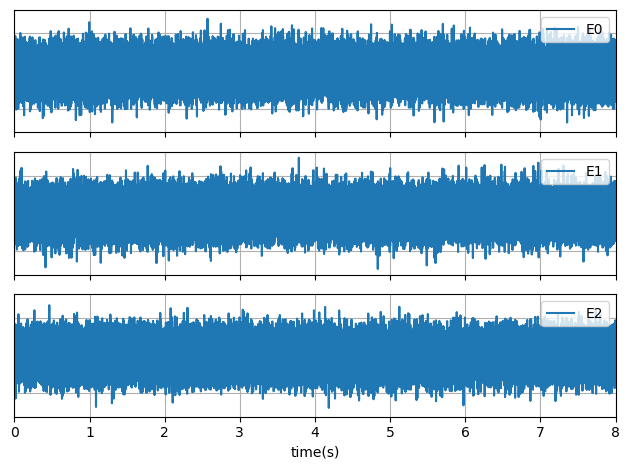

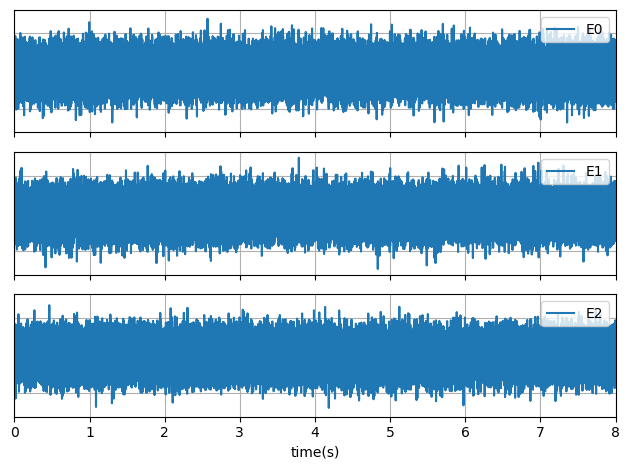

/data/gravwav/jlangend/.conda/envs/NAME_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 0, 'time(s)')

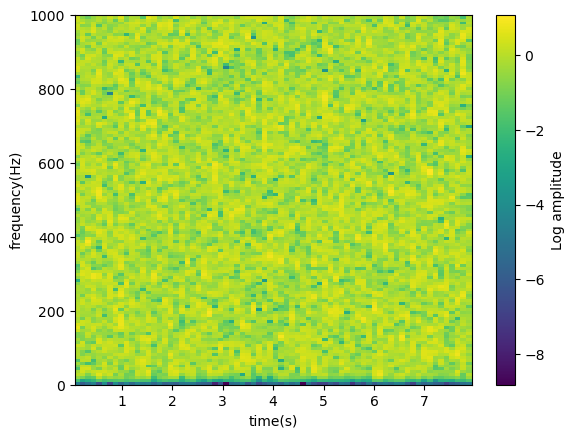

In [12]:
fourier_transform = np.fft.fft(Testset[0][0])
print(fourier_transform.shape)
import matplotlib.mlab as mlab
import scipy.signal

ID = 51
event_ID = np.tile(data.args['random_draw'],2)[data.args['shuffle_array']][ID]
print('eventID:',event_ID)
strain = Testset[ID][0][1]
print('network output:',model(Testset[ID][0].unsqueeze(0).type(torch.float32)))
print('label:',Testset[ID][1])
plot_sample(Testset[ID][0])
#plt.savefig(f'Background_example{data.args["random_draw"][ID]}.pdf')
plt.show()
plot_sample(torch.tensor(np.load(path+f'/Background/Whitened/background_wf{event_ID}.npy.html').T[0:3]))
plt.savefig(f'Misclassified_background_as_signal{event_ID}.pdf')
plt.show()
fs=2*4096

time, strain_fourier = scipy.signal.periodogram(strain[8*fs:],fs)

NFFT = int(fs/8)
spectrum, frequencies ,bins=mlab.specgram(strain, NFFT=NFFT, Fs=fs, window=np.blackman(NFFT))

plt.pcolormesh(bins,frequencies,np.log10(spectrum))#,vmin=0,vmax=1)
plt.colorbar(label='Log amplitude')
plt.axis([None,None,0,1000])
plt.ylabel('frequency(Hz)')
plt.xlabel('time(s)')
#plt.savefig(f'Background_frequencymap{data.args["random_draw"][ID]}.pdf')

**load epoch checkpoint**

In [3]:
#Output name
output_name = 'Net5_longTest'
output_path = f'output/{output_name}'

#loaded epoch
epoch = -1

#-#load checkpoint
model_checkpoints = [str(f) for f in Path(f'{output_path}/').glob("checkpoint_*")]
sorted_model_checkpoint = sorted(model_checkpoints, key=lambda x:float(x.split(f"checkpoint_epoch_")[1].split("_loss")[0]))
checkpoint = torch.load(sorted_model_checkpoint[epoch],map_location=torch.device(device))

#Set the correct values
loaded_epoch = checkpoint['epoch'] 
print(f'loaded epoch:{loaded_epoch}')

loaded epoch:199


**Load Network**

In [4]:
#load model architexture
model = Net5()


#Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=0)


#Load the epoch states from checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

**test Network**

In [5]:
C_sig, C_bg, W_sig, W_bg = 0,0,0,0
for ID in range(len(Testset)):
    input_, label = Testset[ID]
    output = model(input_.unsqueeze(0).type(torch.float32))
    output = output.detach().numpy()[0]
    #print(label,output)
    if label[0]>label[1] and output[0]>output[1]:
        C_sig +=1
        #print("Correct Signal")
    if label[0]<label[1] and output[0]<output[1]:
        C_bg +=1
        #print("Correct Background")
    if label[0]>label[1] and output[0]<output[1]:
        W_sig +=1
        print(data.args['random_draw'][ID%testsize],ID)
        print("Wrong Signal")
    if label[0]<label[1] and output[0]>output[1]:
        W_bg += 1
        print(data.args['random_draw'][ID%testsize],ID)
        print("Wrong Background")
        
#label to right or wrong of network guess    
Confusion_matrix = [[C_sig, C_bg],[ W_sig, W_bg]]
print('Confusion Matrix:\n \t Signal  Background \n Right \t {} \t {}\n Wrong \t {} \t {}'.format(Confusion_matrix[0][0],Confusion_matrix[0][1],Confusion_matrix[1][0],Confusion_matrix[1][1]))

14847 50
Wrong Signal
13850 51
Wrong Signal
13859 70
Wrong Background
14496 142
Wrong Background
14523 175
Wrong Background
14486 185
Wrong Background
13662 188
Wrong Background
13573 225
Wrong Background
Confusion Matrix:
 	 Signal  Background 
 Right 	 126 	 122
 Wrong 	 2 	 6


**plot loss curves**

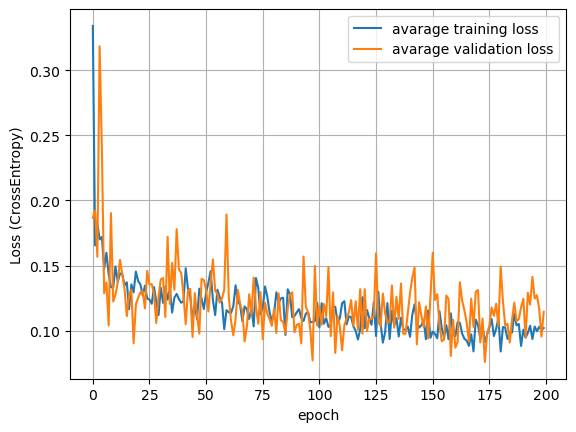

In [87]:
#-#load checkpoint
model_checkpoints = [str(f) for f in Path(f'{output_path}/').glob("checkpoint_*")]
sorted_model_checkpoints = sorted(model_checkpoints, key=lambda x:float(x.split(f"checkpoint_epoch_")[1].split("_loss")[0]))

training_losses = []
validation_losses = []
for epoch in range(len(sorted_model_checkpoints)):
    checkpoint = torch.load(sorted_model_checkpoint[epoch],map_location=torch.device(device))
    training_losses.append(checkpoint['avarage_train_loss'])
    validation_losses.append(checkpoint['avarage_val_loss'])

plt.figure()
plt.plot(training_losses,label='avarage training loss')
plt.plot(validation_losses, label= 'avarage validation loss')
plt.legend()
plt.grid()
plt.ylabel('Loss (CrossEntropy)')
plt.xlabel('epoch')
plt.show()

In [163]:
np.linalg.norm(spectrum,axis=0)

array([  33.07341995,   34.15617768,   38.8828972 ,   36.92839395,
         32.79313676,   34.39713569,   31.4158524 ,   34.34722728,
         33.80764984,   35.38210635,   37.32648972,   31.31639337,
         32.77889636,   30.72638222,   31.60189163,   35.91765827,
         36.87440193,   31.35626219,   33.02333705,   33.25619856,
         29.63937499,   33.62418959,   36.57138952,   30.02838869,
         32.78556237,   35.50683356,   31.89227448,   35.49410253,
         36.14391924,   35.38654405,   33.66197347,   33.76831007,
         33.43415682,   33.20273587,   30.62148596,   34.26375515,
         31.92585565,   37.35056928,   35.51980955,   32.50268656,
         32.37668872,   33.38780127,   34.70900295,   34.43488427,
         35.07429052,   33.06978687,   40.00298182,   41.03194593,
         37.28638524,   35.92790243,   40.22986965,   45.23261564,
       3235.0662686 ,   43.15192398,   42.00772061,   32.63761563,
         35.97516557,   36.69343127,   39.07932866,   35.05501